# Test User Afib Detection

I found a volunteer to donate their fitbit heart rate data and a log of their atrial fibulation (afib) episodes, this notebook will endeavor to build a detector that can automatically recognize afib episodes.

In [1]:
import pandas as pd
import json

import psycopg2
conn = psycopg2.connect(host='ec2-107-20-166-28.compute-1.amazonaws.com',
                        user='rbhciitblovwew',
                        database='db274el0c49tdu')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={"figure.figsize": (16, 9)})
sns.set(style="whitegrid")

In [2]:
query = """
SELECT *
FROM activity_journal_minutes
WHERE user_id = 2
AND heart_dttm BETWEEN '2016-08-07' AND '2016-12-27'
"""
comb_journals = pd.read_sql(query, conn, parse_dates=['step_dttm', 'heart_dttm', 'journal_date'])
comb_journals.head()

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm
0,2,0,58,2016-08-07,2016-08-07 00:00:00,2016-08-07 00:00:00
1,2,0,58,2016-08-07,2016-08-07 00:01:00,2016-08-07 00:01:00
2,2,0,58,2016-08-07,2016-08-07 00:02:00,2016-08-07 00:02:00
3,2,0,58,2016-08-07,2016-08-07 00:03:00,2016-08-07 00:03:00
4,2,0,58,2016-08-07,2016-08-07 00:04:00,2016-08-07 00:04:00


In [3]:
# NOTE: These dates/times are in PST
episode_log = [
    ['2016-08-08 02:00:00', '2016-08-08 05:07:00'],
    ['2016-09-02 21:15:00', '2016-09-03 02:15:00'],
    ['2016-10-20 16:30:00', '2016-10-20 18:30:00'],
    ['2016-11-07 16:30:00', '2016-11-07 19:00:00'],
    ['2016-12-14 15:15:00', '2016-12-14 17:45:00'],
    ['2016-12-24 03:20:00', '2016-12-24 06:00:00'],
    ['2016-12-26 08:00:00', '2016-12-26 09:45:00']
]

In [4]:
# Label each record as in afib or not
comb_journals['afib'] = False

for log in episode_log:
    episode_start = pd.to_datetime(log[0])#.tz_localize('US/Pacific').tz_convert(None)
    episode_end = pd.to_datetime(log[1])  #.tz_localize('US/Pacific').tz_convert(None)
    comb_journals['afib'][ (comb_journals['heart_dttm'] >= episode_start) &
                   (comb_journals['heart_dttm'] <  episode_end)
                 ] = True

    
comb_journals.groupby('afib').count().transpose()

/home/brycemcd/anaconda2/envs/typical_stack/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


user_id         1151
steps           1151
bpm             1151
journal_date    1151
step_dttm       1151
heart_dttm      1151
afib            1151
dtype: int64

In [17]:
comb_journals.groupby('journal_date')[['bpm', 'steps']].describe()

bpm        steps
journal_date                                
2016-08-07   count  1322.000000  1322.000000
             mean     62.692890     4.028744
             std      13.162621    11.267879
             min      44.000000     0.000000
             25%      54.000000     0.000000
             50%      60.000000     0.000000
             75%      69.000000     0.000000
             max     111.000000   110.000000
2016-08-08   count  1310.000000  1310.000000
             mean     65.013740     4.750382
             std      13.829579    15.289250
             min      46.000000     0.000000
             25%      56.000000     0.000000
             50%      61.000000     0.000000
             75%      70.000000     0.000000
             max     130.000000   110.000000
2016-08-09   count   916.000000   916.000000
             mean     66.040393     5.112445
             std      11.899833    14.566352
             min      46.000000     0.000000
             25%      58.000000     0.000000
             50%      64.000000     0.000000
             75%      71.000000     0.000000
             max     114.000000   106.000000
2016-08-10   count   978.000000   978.000000
             mean     68.406953     8.479550
             std      12.192672    16.267911
             min      51.000000     0.000000
             25%      61.000000     0.000000
             50%      66.000000     0.000000
...                         ...          ...
2016-12-24   std      17.123753     7.820255
             min      45.000000     0.000000
             25%      60.000000     0.000000
             50%      65.000000     0.000000
             75%      77.000000     0.000000
             max     188.000000    82.000000
2016-12-25   count  1399.000000  1399.000000
             mean     66.130808     2.508935
             std      16.320973     7.510300
             min      45.000000     0.000000
             25%      55.000000     0.000000
             50%      61.000000     0.000000
             75%      73.500000     0.000000
             max     125.000000    62.000000
2016-12-26   count  1369.000000  1369.000000
             mean     61.824690     1.286340
             std      11.775244     5.720830
             min      48.000000     0.000000
             25%      55.000000     0.000000
             50%      59.000000     0.000000
             75%      63.000000     0.000000
             max     132.000000    78.000000
2016-12-27   count     1.000000     1.000000
             mean     52.000000     0.000000
             std            NaN          NaN
             min      52.000000     0.000000
             25%      52.000000     0.000000
             50%      52.000000     0.000000
             75%      52.000000     0.000000
             max      52.000000     0.000000

[936 rows x 2 columns]

In [ ]:
sns.stripplot(data=comb_journals, y='bpm', x='afib', jitter=True)
plt.show()

In [ ]:
comb_journals[ comb_journals['bpm'] > 150 ]

Heart rate alone does not seem to separate the data very well. For graphical purposes, I'll look at the relationship of steps and heart rate.

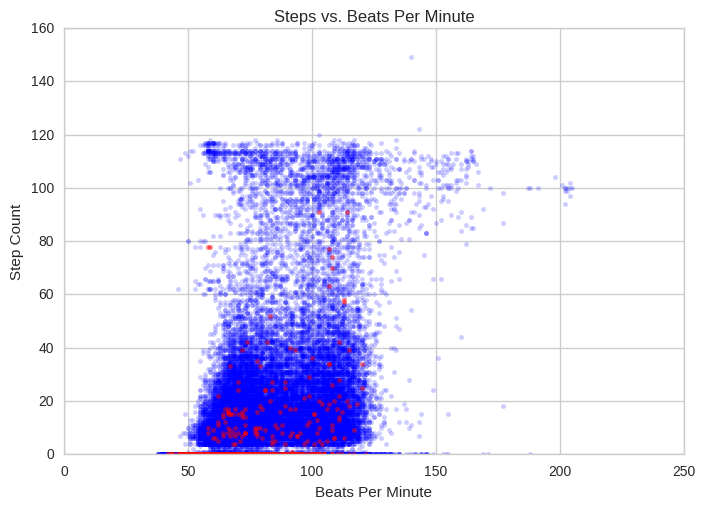

In [18]:
normal = comb_journals[ comb_journals['afib'] == False ]
afib = comb_journals[ comb_journals['afib'] == True ]

plt.plot(normal['bpm'], normal['steps'], 'b.', alpha=0.2)
plt.plot(afib['bpm'], afib['steps'], 'r.', alpha=0.5)

plt.title("Steps vs. Beats Per Minute")
plt.ylabel("Step Count")
plt.xlabel("Beats Per Minute")
plt.show()

In [19]:
comb_journals[['steps', 'bpm']].corr()

,steps,bpm
steps,1.000000,0.455076
bpm,0.455076,1.000000


In [ ]:
comb_journals['hr_to_step_ratio'] = comb_journals['bpm'] / (comb_journals['steps'] + 1) # +1 avoid div by zero errors
comb_journals.head()

In [ ]:
sns.stripplot(data=comb_journals, y='hr_to_step_ratio', x='afib', jitter=True, alpha=0.2)
plt.show()

TODO: There's not much separation in the data and given that some of the labeled afib events show bpm < 60, I think there is a problem matching the event log to the event in the fitbit dataset.

+ Look at API docs to see if step AND bpm data coming from fitbit are both reported in UTC

> Fitbit does not support time zones for data. Users can specify a time zone in their settings, but this offset is only used to determine the start of their 24-hour period. As such, there is no way to request a specific time zone, because all data is aligned with the user's specified UTC offset.

> All date and time related fields in the API requests and responses are rendered in the local time of the resource owner's timezone (either authorized user or the owner of the resource requested).

+ Make sure event log and fitbit data is paired in the same timezone
+ Get feedback from user about what's happening when bpm is > 130 && an event is not reported

In [20]:
comb_journals['heart_time'] = comb_journals['heart_dttm'].dt.time

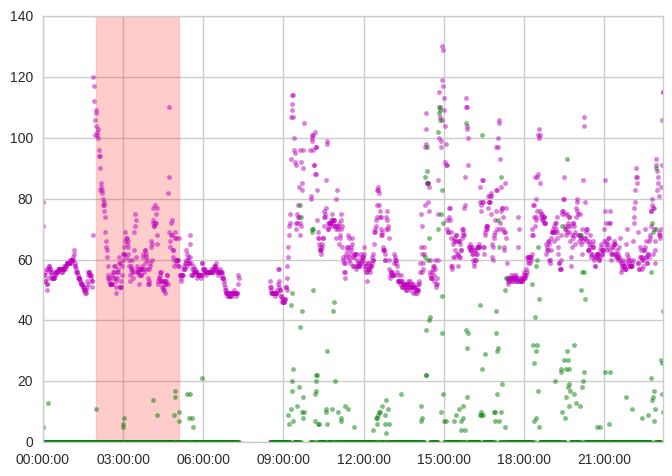

In [110]:
# This will plot a single day
event_day = comb_journals[ comb_journals['journal_date'] == '2016-08-08']
plt.plot(event_day['heart_dttm'], event_day['bpm'], 'm.', alpha=0.5)
plt.plot(event_day['heart_dttm'], event_day['steps'], 'g.', alpha=0.5)
plt.axvspan('2016-08-08 02:00:00', '2016-08-08 05:07:00', color='red', alpha=0.2)
plt.show()

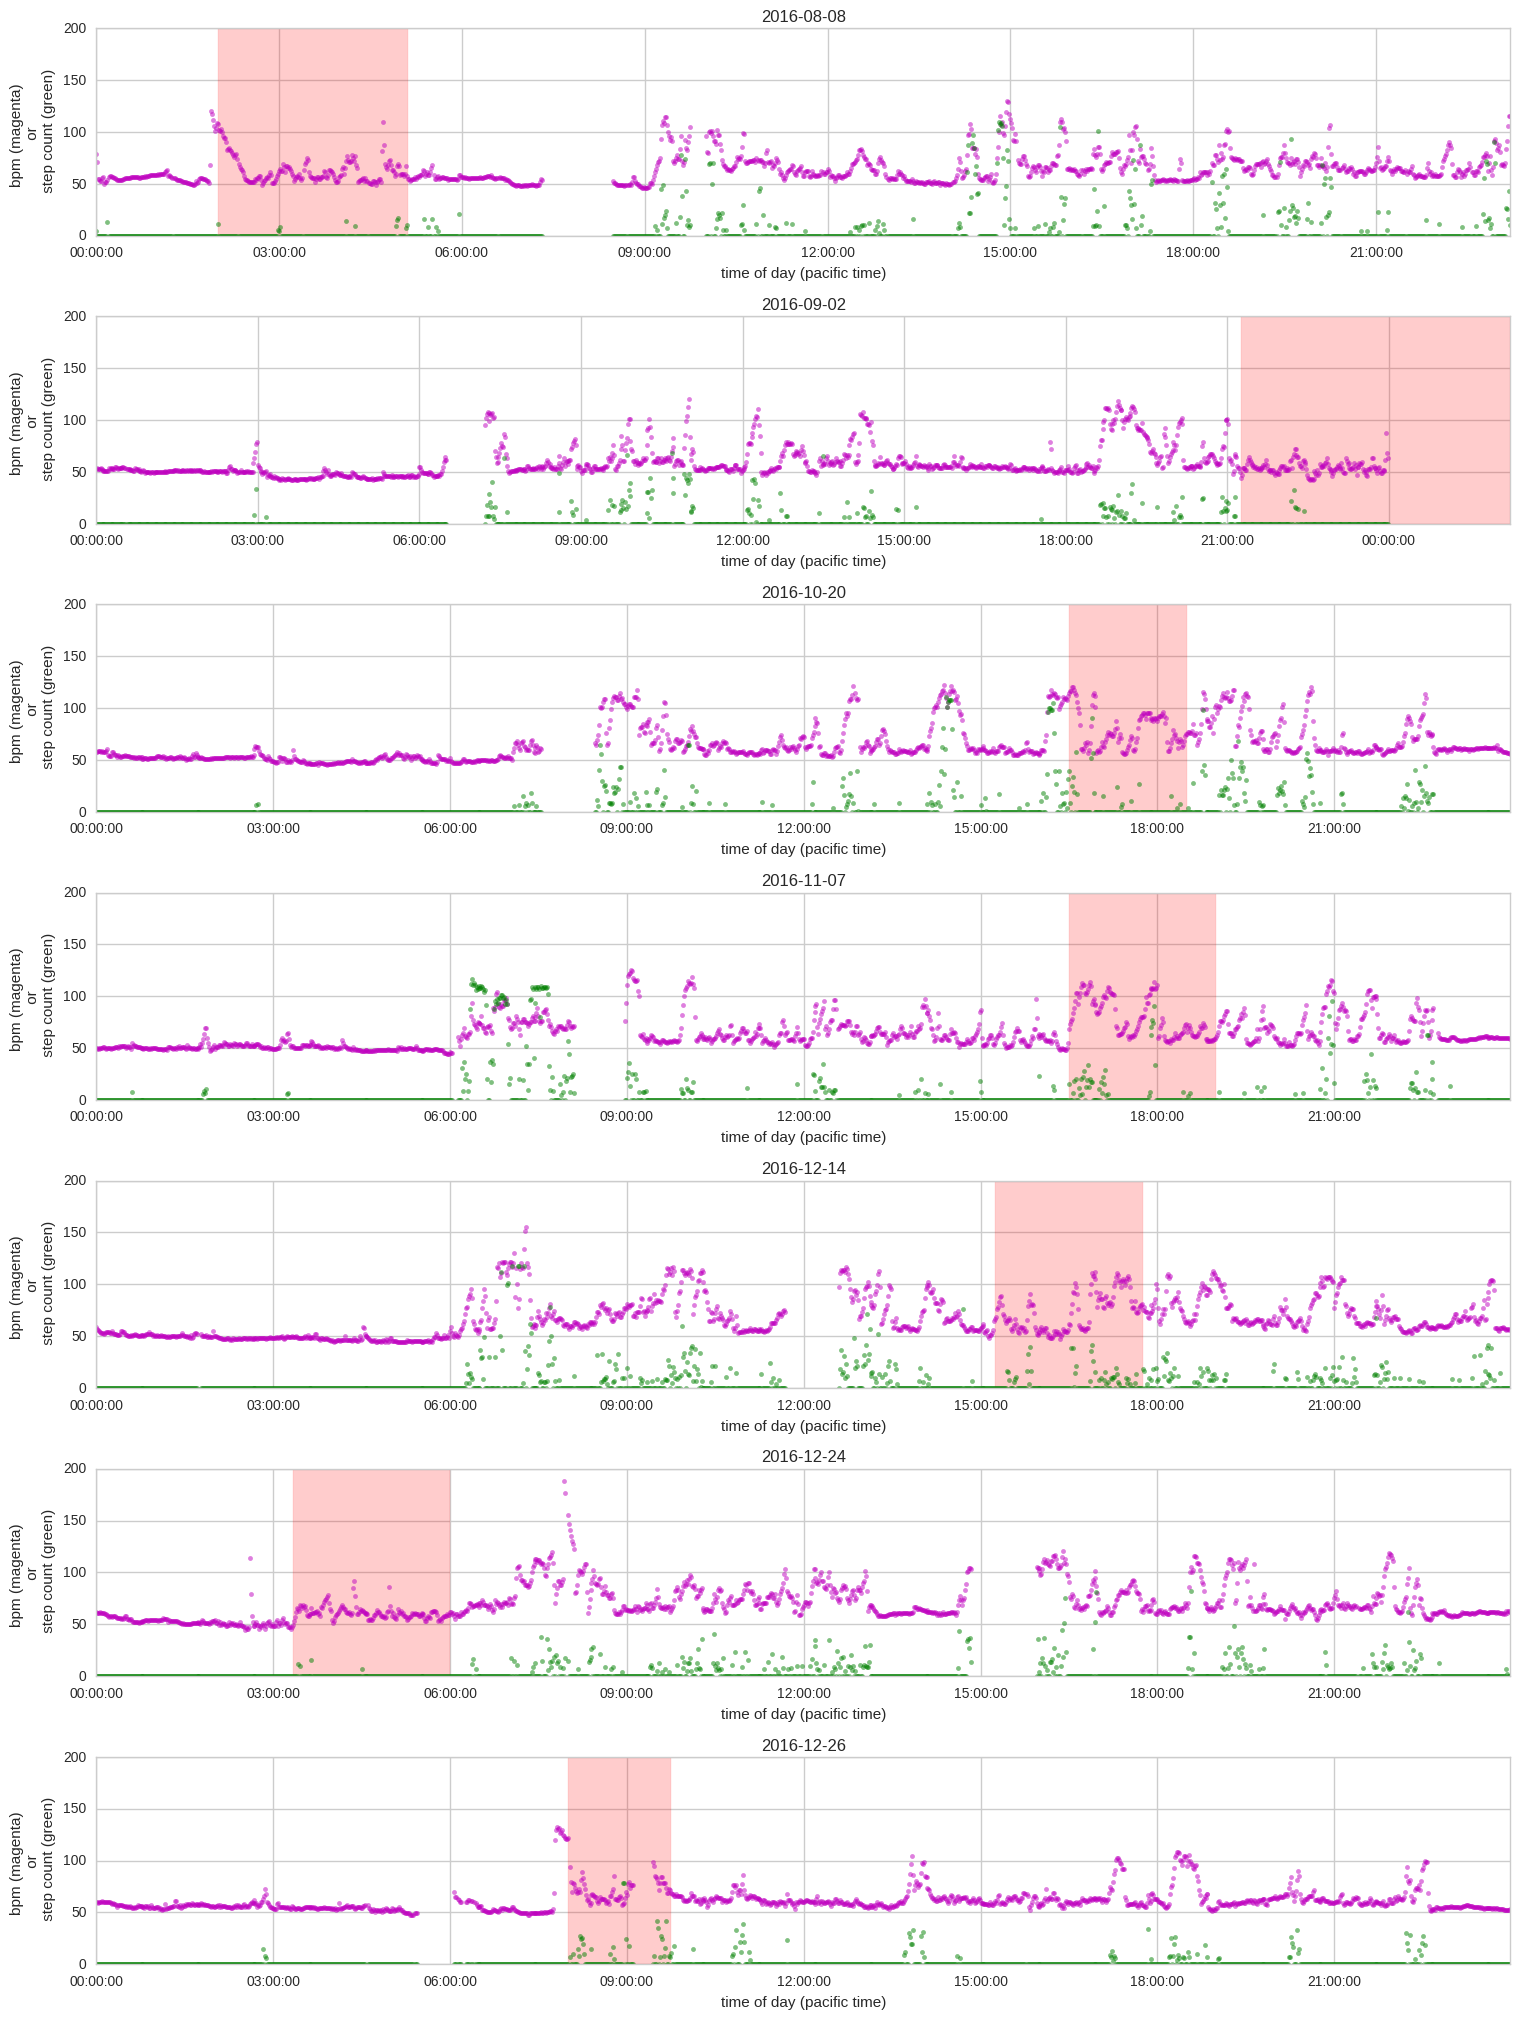

In [149]:
# try plotting the above for each event

# set up subplots
i = 0
total_subplots = len(episode_log)
f, axarr = plt.subplots(total_subplots, sharey=True, figsize=(15, 20))

for event in episode_log:
    event_d = comb_journals[ comb_journals['journal_date'] == pd.to_datetime(event[0]).date()]
    axarr[i].plot(event_d['heart_dttm'], event_d['bpm'], 'm.', alpha=0.5)
    axarr[i].plot(event_d['heart_dttm'], event_d['steps'], 'g.', alpha=0.5)
    axarr[i].axvspan(event[0], event[1], color='red', alpha=0.2)
    
    axarr[i].set_title(pd.to_datetime(event[0]).date())
    axarr[i].set_ylabel('bpm (magenta) \n or \n step count (green)')
    axarr[i].set_xlabel('time of day (pacific time)')
    i = i + 1
    
    
plt.tight_layout(pad=0.0, h_pad=1.0)
plt.show()

There is a lot of overlap in the raw data irrespective of an afib event. I'm going to attempt to smooth out some of the events and use different measures to see if more obvious patterns emerge

In [133]:
event_day = comb_journals[ comb_journals['journal_date'] == '2016-08-08' ]
var_window = '10min'
variances = event_day[['heart_dttm', 'bpm', 'steps']].rolling(window=var_window, on='heart_dttm').var()
# TODO: I've confirmed this time difference is 10 minutes = 600 seconds but it's not clear why values for the variance
# would be set in the sencond cell. I would have expected cell 9 to have the first value on a window of 10 minutes
# window = 10 is not the same as window = 10min

variances.rename(columns={'bpm' : 'bpm_var', 'steps' : 'step_var'}, inplace=True)
variances.fillna(0, inplace=True)
#event_day.set_index('heart_dttm').head() 
#variances.set_index('heart_dttm').head()
with_vars = event_day.set_index('heart_dttm').join(variances.set_index('heart_dttm'), rsuffix="_doop").reset_index()

with_vars.head(n=30)

,heart_dttm,user_id,steps,bpm,journal_date,step_dttm,afib,heart_time,bpm_var,step_var
0,2016-08-08 00:00:00,2,5,79,2016-08-08,2016-08-08 00:00:00,False,00:00:00,0.000000,0.000000
1,2016-08-08 00:01:00,2,0,71,2016-08-08,2016-08-08 00:01:00,False,00:01:00,32.000000,12.500000
2,2016-08-08 00:02:00,2,0,55,2016-08-08,2016-08-08 00:02:00,False,00:02:00,149.333333,8.333333
3,2016-08-08 00:03:00,2,0,55,2016-08-08,2016-08-08 00:03:00,False,00:03:00,144.000000,6.250000
4,2016-08-08 00:04:00,2,0,53,2016-08-08,2016-08-08 00:04:00,False,00:04:00,136.800000,5.000000
5,2016-08-08 00:05:00,2,0,53,2016-08-08,2016-08-08 00:05:00,False,00:05:00,124.800000,4.166667
6,2016-08-08 00:06:00,2,0,56,2016-08-08,2016-08-08 00:06:00,False,00:06:00,107.571429,3.571429
7,2016-08-08 00:07:00,2,0,57,2016-08-08,2016-08-08 00:07:00,False,00:07:00,93.553571,3.125000
8,2016-08-08 00:08:00,2,0,50,2016-08-08,2016-08-08 00:08:00,False,00:08:00,92.694444,2.777778
9,2016-08-08 00:09:00,2,0,52,2016-08-08,2016-08-08 00:09:00,False,00:09:00,86.988889,2.500000


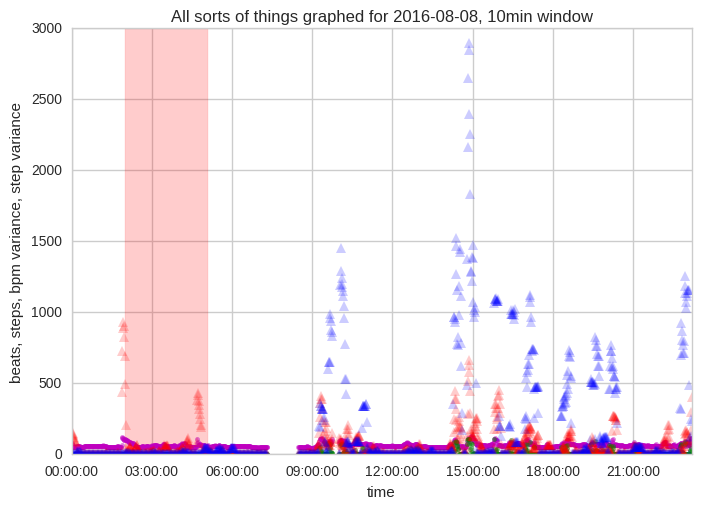

In [147]:
normal = with_vars[ with_vars['afib'] == False ]
afib = with_vars[ with_vars['afib'] == True ]

# raw steps and beats
plt.plot(with_vars['heart_dttm'], with_vars['bpm'], 'm.', alpha=0.5)
plt.plot(with_vars['heart_dttm'], with_vars['steps'], 'g.', alpha=0.5)

# measures from the above cell
plt.plot(with_vars['heart_dttm'], with_vars['bpm_var'], 'r^', alpha=0.2)
plt.plot(with_vars['heart_dttm'], with_vars['step_var'], 'b^', alpha=0.2)

# highlight afib area
plt.axvspan('2016-08-08 02:00:00', '2016-08-08 05:07:00', color='red', alpha=0.2)


plt.title("All sorts of things graphed for 2016-08-08, %s window" % var_window)
plt.xlabel('time')
plt.ylabel('beats, steps, bpm variance, step variance')
#plt.ylim([0, 250])
plt.show()

There might be something here. I don't want to dive too deep into feature engineering but I can see where the red triangles spike in absence of a blue triangle spike. Similarly, normal periods seem to have blue triangle spikes but red triangles have an associated, albiet smaller in magnitude, spike as well.

These spikes indicate variance. Red triangles are bpm variance and blue triangles are step variance.

afib detetection could be associated with spikes in bpm variance without associated step variance.

I'll now try it on the larger data set:

In [153]:
var_window = '10min'
variances = comb_journals[['heart_dttm', 'bpm', 'steps']].rolling(window=var_window, on='heart_dttm').var()
# TODO: I've confirmed this time difference is 10 minutes = 600 seconds but it's not clear why values for the variance
# would be set in the sencond cell. I would have expected cell 9 to have the first value on a window of 10 minutes
# window = 10 is not the same as window = 10min

variances.rename(columns={'bpm' : 'bpm_var', 'steps' : 'step_var'}, inplace=True)
variances.fillna(0, inplace=True)
#event_day.set_index('heart_dttm').head() 
#variances.set_index('heart_dttm').head()
with_vars = comb_journals.set_index('heart_dttm').join(variances.set_index('heart_dttm'), rsuffix="_doop").reset_index()

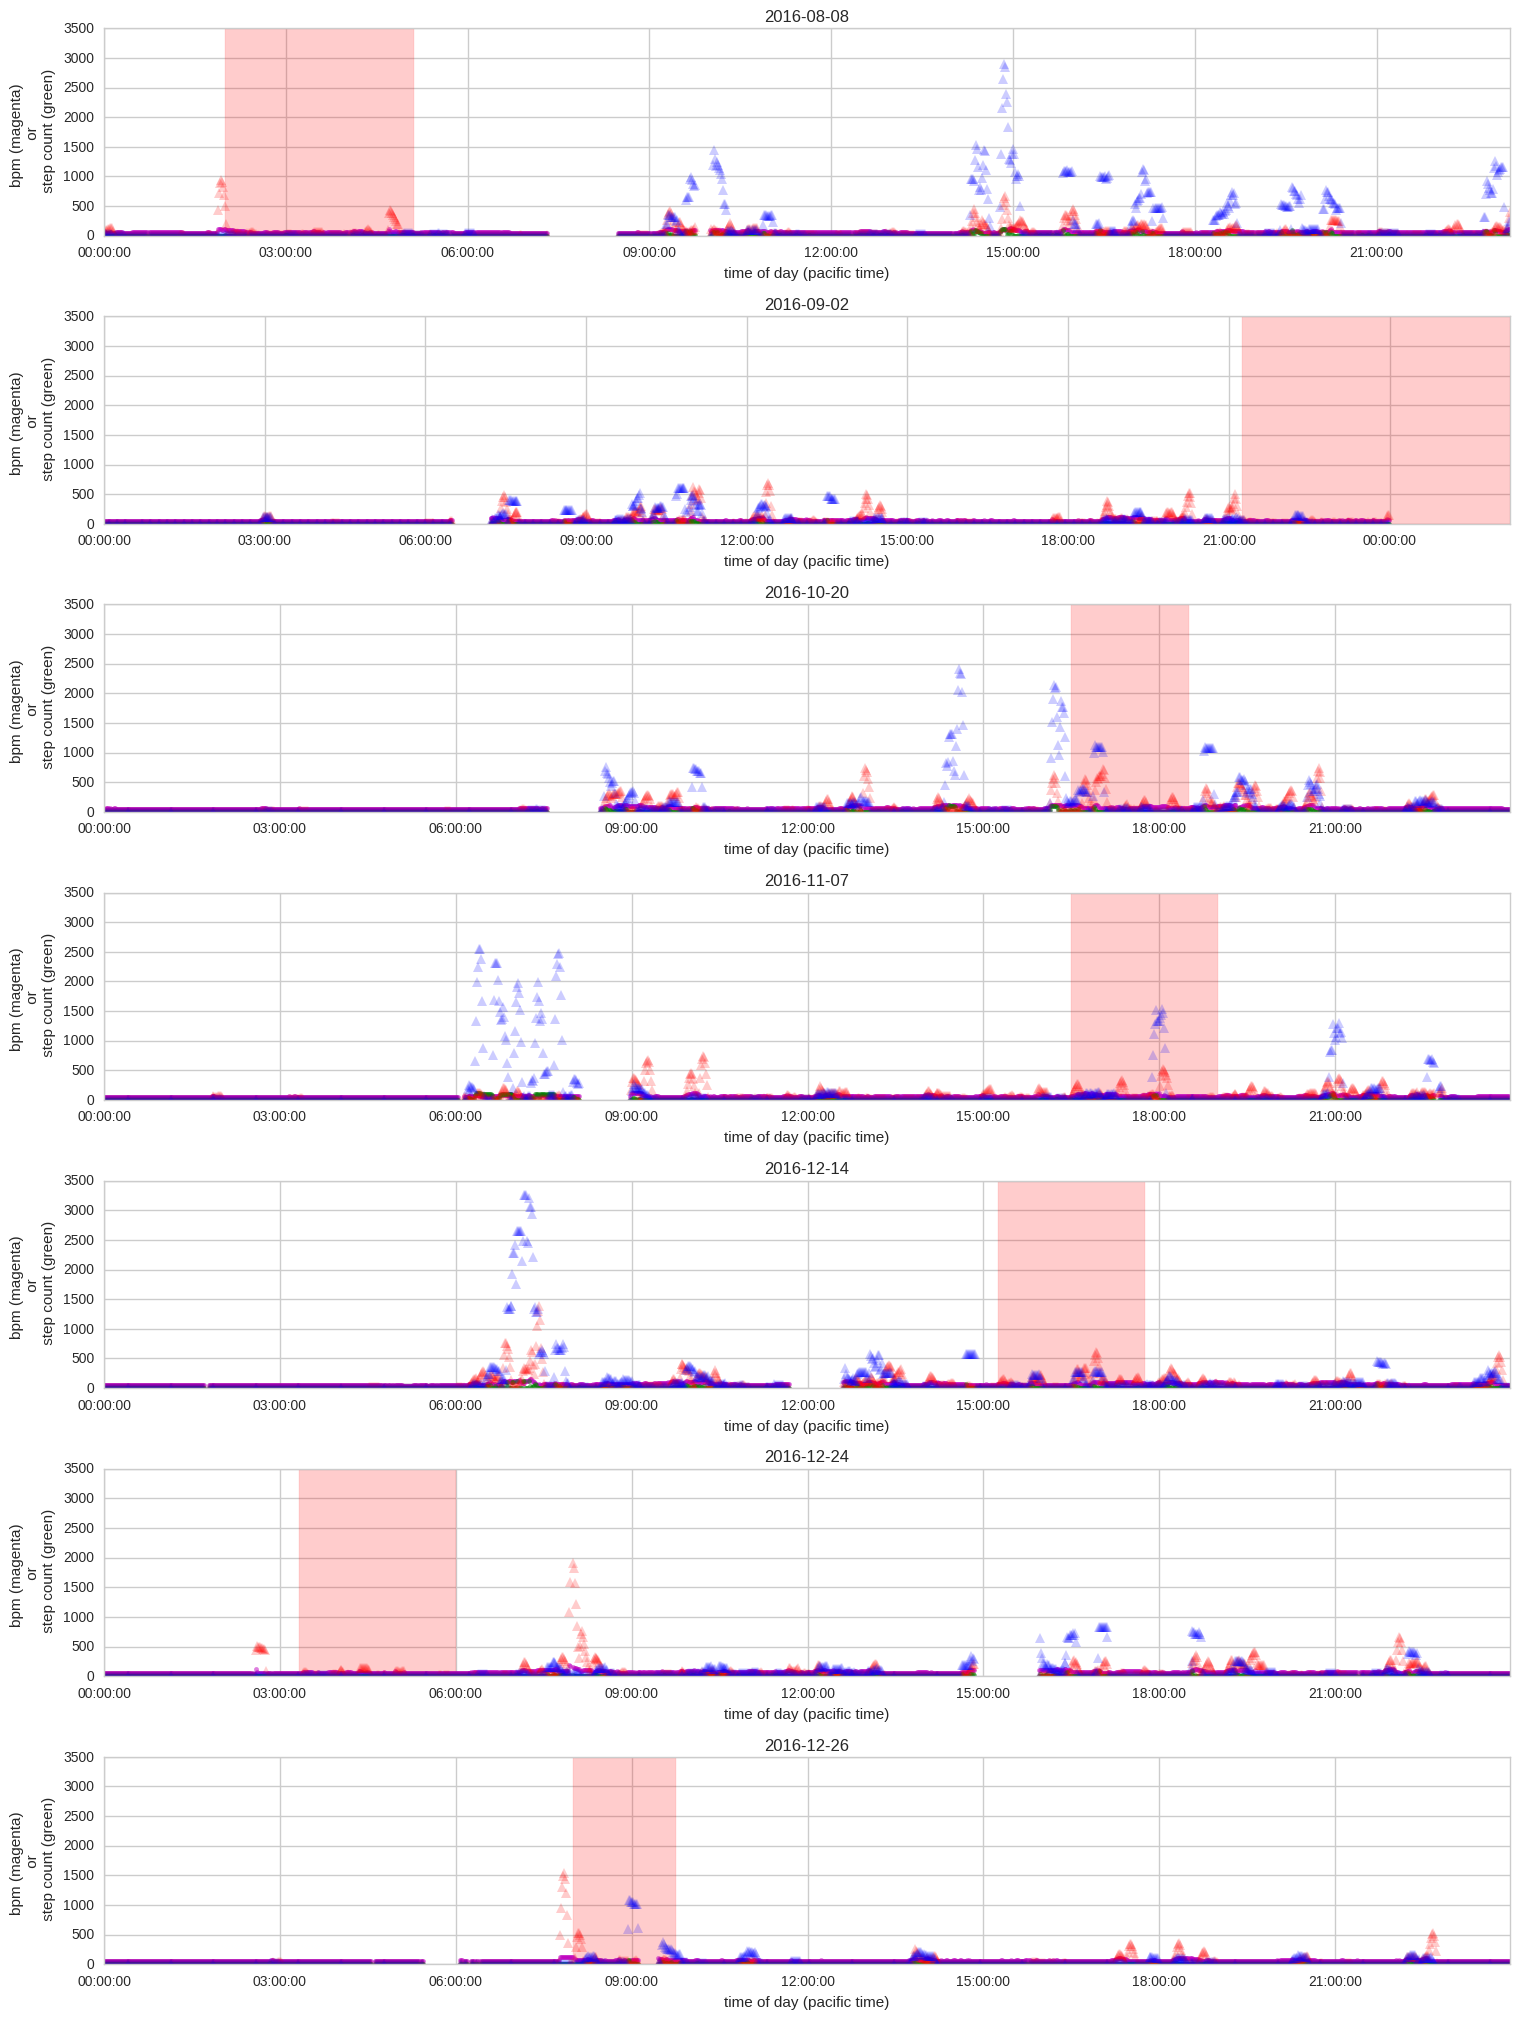

In [156]:
# try plotting the above for each event

# set up subplots
i = 0
total_subplots = len(episode_log)
f, axarr = plt.subplots(total_subplots, sharey=True, figsize=(15, 20))

for event in episode_log:
    event_d = with_vars[ comb_journals['journal_date'] == pd.to_datetime(event[0]).date()]
    axarr[i].plot(event_d['heart_dttm'], event_d['bpm'], 'm.', alpha=0.5)
    axarr[i].plot(event_d['heart_dttm'], event_d['steps'], 'g.', alpha=0.5)
    
    axarr[i].axvspan(event[0], event[1], color='red', alpha=0.2)
    
    axarr[i].plot(event_d['heart_dttm'], event_d['bpm_var'], 'r^', alpha=0.2)
    axarr[i].plot(event_d['heart_dttm'], event_d['step_var'], 'b^', alpha=0.2)
    
    axarr[i].set_title(pd.to_datetime(event[0]).date())
    axarr[i].set_ylabel('bpm (magenta) \n or \n step count (green)')
    axarr[i].set_xlabel('time of day (pacific time)')
    i = i + 1
    
    
plt.tight_layout(pad=0.0, h_pad=1.0)
plt.show()

The relationship is not obvious and I think there are some weaknesses in getting great detetection in that this data is using self-report for detection of the events and it's using a non-medical grade instrument for passive monitoring.

Despite these weaknesses, I think there are some patterns in the data that warrant some further investigation with the user and perhaps some model training.